In [1]:
library(ggplot2)
library(ComplexHeatmap)
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: ggpubr

Loading required package: magrittr

Loading required package: checkmate

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading 'meta' package (version 6.2-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
o

In [2]:
datasets = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_with_therapy.rds")
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
ref_path_OS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival_pm.rds")
ref_path_PFS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_PFS_total_survival_pm.rds")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)

In [3]:
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(datasets[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

datasets_overview[c("dataset2","dataset6","dataset8","dataset10","dataset11","dataset12","dataset13","dataset14","dataset20"),"RNA"] = TRUE

In [4]:
# 这是旧版本dataset_overview的归纳
datasets_overview$Cancer_type2 = datasets_overview$Cancer_type
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Renal Cell Carcinoma","Renal Cell Carcinoma","Clear cell renal cell carcinoma")] = "Renal Cell Carcinoma"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Bladder Cancer","Urothelial cancer")] = "Urothelial Cancer"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Esophagogastric Cancer","Gastrointestinal cancer","Colorectal Cancer","Gastric cancer","Neuroendocrine neoplasms","Gastrointestinal cancer","Hepatocellular carcinoma")] = "Gastrointestinal Cancer"
# datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
#                                c("Glioblastoma","Glioma")] = "Glioblastoma"
datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
                               c("Esophagogastric Cancer","Colorectal Cancer","Pan-GI cancer","Neuroendocrine tumours","Hepatocellular carcinoma")] = "Gastrointestinal Cancer"

In [5]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = datasets_names$Cohort_name

In [6]:
ref_single = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival.rds")

In [7]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1
dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

# 0.05

### OS

In [68]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.05) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [69]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [10]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [11]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [12]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [13]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [14]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [16]:
OS_RS_matrix = RS_matrix

### PFS

In [17]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.05) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [18]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [19]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [20]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [21]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [22]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [23]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [25]:
PFS_RS_matrix = RS_matrix

In [26]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [28]:
OS_RS_matrix2_0.05 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),]

# 0.1

### OS

In [32]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.1) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [33]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [34]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [35]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [36]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [37]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [38]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [40]:
OS_RS_matrix = RS_matrix

### PFS

In [41]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.1) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [42]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [43]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [44]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [45]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [46]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [47]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [49]:
PFS_RS_matrix = RS_matrix

In [50]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [52]:
OS_RS_matrix2_0.1 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),]

# 0.15

### OS

In [53]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.15) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [54]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [55]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [56]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [57]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [58]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [59]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [61]:
OS_RS_matrix = RS_matrix

### PFS

In [62]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.15) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [63]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [64]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [65]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [66]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [67]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [68]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [70]:
PFS_RS_matrix = RS_matrix

In [71]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [73]:
OS_RS_matrix2_0.15 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),]

# 0.2

### OS

In [74]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.2) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [75]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [76]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [77]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [78]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [79]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [80]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [82]:
OS_RS_matrix = RS_matrix

### PFS

In [83]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.2) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [84]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [85]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [86]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [87]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [88]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [89]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [91]:
PFS_RS_matrix = RS_matrix

In [92]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [94]:
OS_RS_matrix2_0.2 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),]

# 0.25

### OS

In [95]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.25) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [96]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [97]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [98]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [99]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [100]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [101]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [103]:
OS_RS_matrix = RS_matrix

### PFS

In [104]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.25) # 两个组至少包含的患者数是总人数的5%
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [105]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [106]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [107]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [108]:
# 每个瘤种为一个单位，计算单瘤种的数据集鲁棒性,为了让具有更多的数据集的瘤种在计算得分时，具有更高的赋值，所以计算平均数据集得分后，会乘以一个同方向数据集个数
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    seq_weight = ifelse(datasets_overview[tmp_datasets,"Sequencing"] == "Panel",0.5,1)
    cn = paste(i,"seq",sep = "_")
    RS_matrix[[cn]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
#         meanscore = sum(x[ x != 0 ] * seq_weight[ x != 0 ])/sum( x != 0)
        meanscore = mean(x[x != 0 ])
        meanscore2 = ifelse(sign(meanscore) == 1,meanscore*sum(seq_weight[x>0]),meanscore*sum(seq_weight[x<0]))
        
        return(meanscore2)
    })
    RS_matrix[[cn]][is.na(RS_matrix[[cn]])] = 0
}

In [109]:
# 简单的加和可能会导致某些在个别数据集上表现特别好的基因过分地增大了最后得分
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_seq = apply(RS_matrix[,paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_")],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean_seq = apply(RS_matrix[,setdiff(paste(unique(datasets_overview$Cancer_type2),"seq",sep = "_"),
                                                              c("Pan-cancer_seq","Microsatellite-stable solid tumors_seq"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [110]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [112]:
PFS_RS_matrix = RS_matrix

In [113]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [115]:
OS_RS_matrix2_0.25 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),]

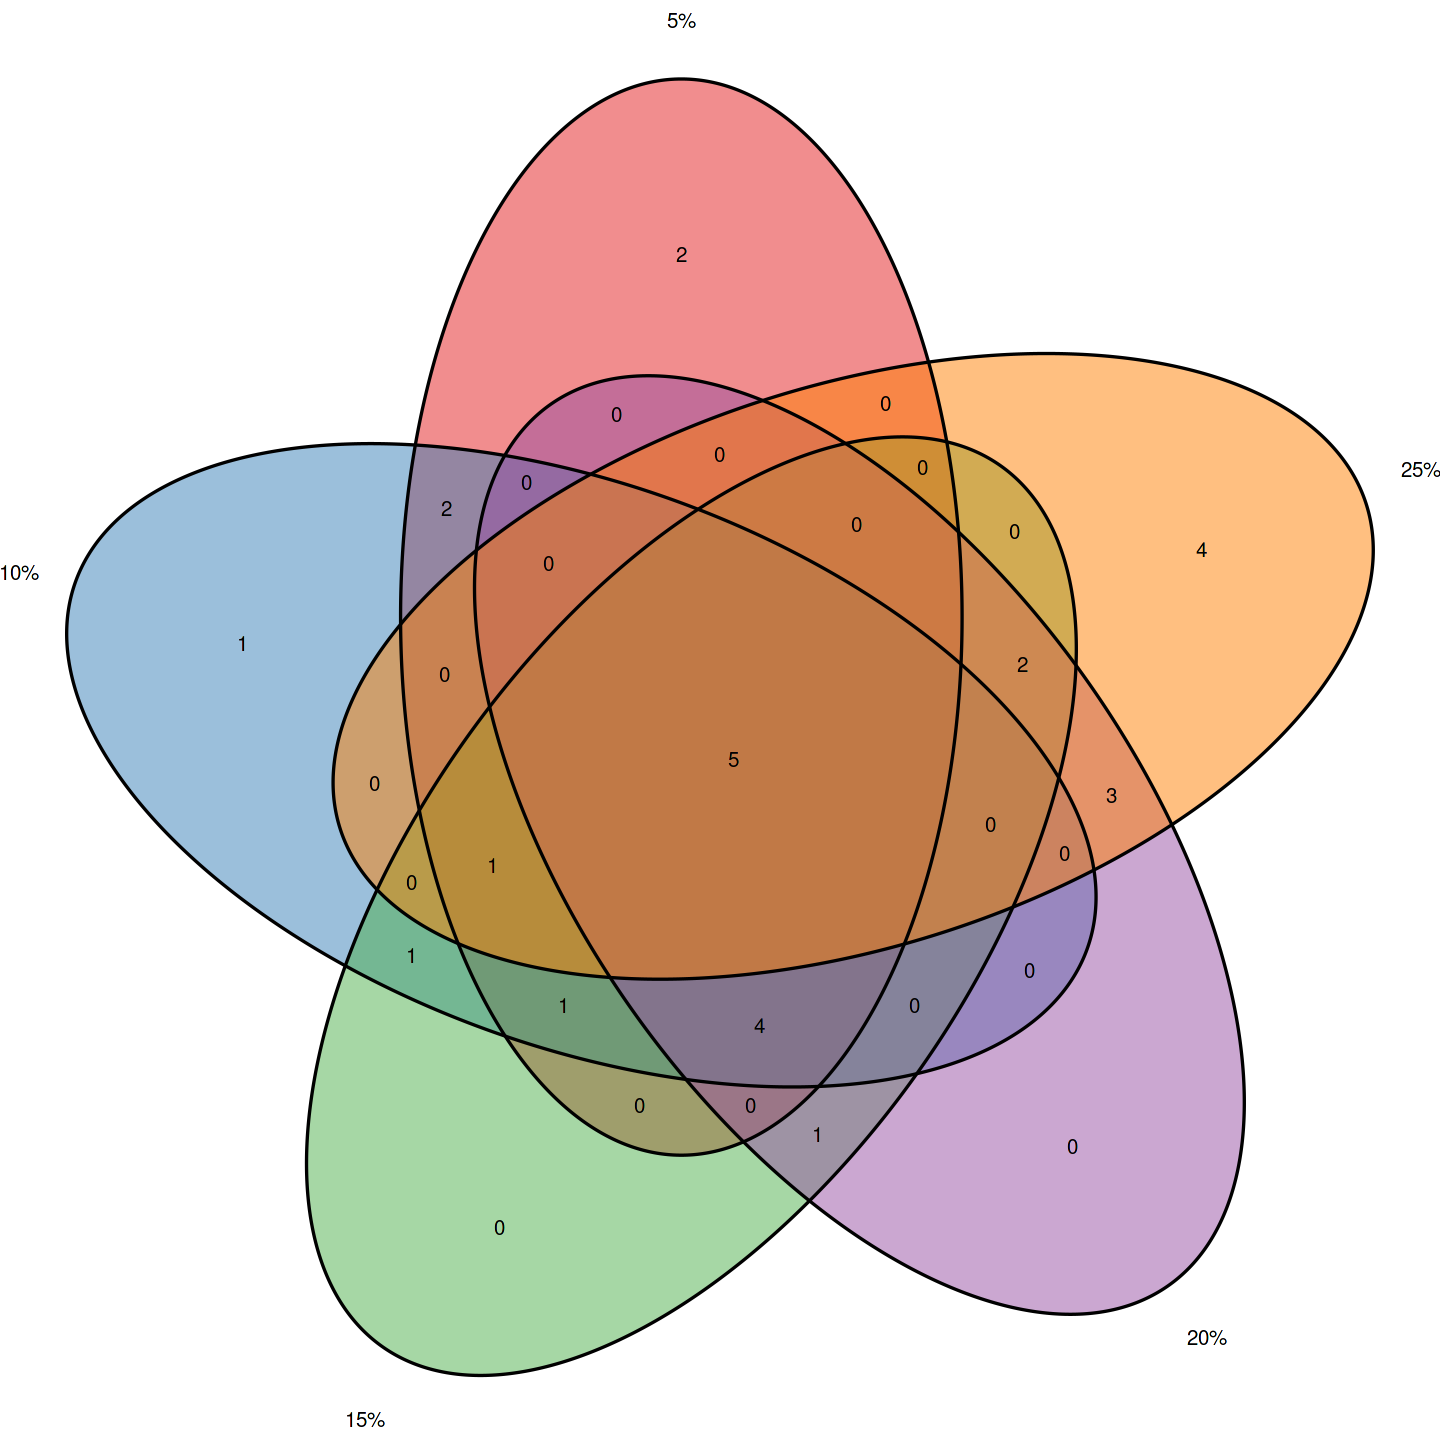

In [168]:
library(RColorBrewer)
library(VennDiagram)

options(repr.plot.height =12, repr.plot.width = 12)
grid.draw(venn.diagram(
              x = list(
                "5%" = rownames(OS_RS_matrix2_0.05)[1:15],
                "10%" = rownames(OS_RS_matrix2_0.1)[1:15],
                "15%" = rownames(OS_RS_matrix2_0.15)[1:15],
                "20%" = rownames(OS_RS_matrix2_0.2)[1:15],
                "25%" = rownames(OS_RS_matrix2_0.25)[1:15]
                                ),
              filename = NULL,
              fill = brewer.pal(5, "Set1")
            ))

In [169]:
sort(table(c(rownames(OS_RS_matrix2_0.05)[1:15],
rownames(OS_RS_matrix2_0.1)[1:15],
rownames(OS_RS_matrix2_0.15)[1:15],
rownames(OS_RS_matrix2_0.2)[1:15],
rownames(OS_RS_matrix2_0.25)[1:15],
rownames(OS_RS_matrix2_0.3)[1:15])),decreasing = T)


                             GOBP_CELLULAR_RESPONSE_TO_HEAT 
                                                          6 
                            GOBP_POST_EMBRYONIC_DEVELOPMENT 
                                                          6 
                   GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION 
                                                          6 
                  GOBP_REGULATION_OF_ORGANIC_ACID_TRANSPORT 
                                                          6 
                                    GOBP_THYMUS_DEVELOPMENT 
                                                          6 
                        GOBP_AMMONIUM_ION_METABOLIC_PROCESS 
                                                          4 
                               GOBP_CHROMOSOME_CONDENSATION 
                                                          4 
                            GOBP_NON_RECOMBINATIONAL_REPAIR 
                                                          4 
                  GOBP_